# Tutorial: Image colourisation - Horsehead nebula

<br>
<br>

<img style="position: absolute; right: 60px; top: 40px; height: 160px; width: 160px" src="https://datalabs.esa.int/datalab-icon/c11e47af-7ce9-4281-b3b5-475a180a256f" /> 

**Author(s):** Kristin Anett Remmelgas

**Last modified:** 14.03.2025

**Notebook summary**

This notebook illustrates the basic concepts behind astronomical image colourisation by using the Euclid ERO image of the horsehead nebula. This notebook was originally created for the ESA Young Professional Event 2024 and aimed at people with little to no background in astronomical data processing and should therefore be considered outreach material rather than a fully scientific approach.

**Useful links:**

* [ERO data release information ](https://www.cosmos.esa.int/web/euclid/ero-public-release)
* [Astropy function make_lupton_rgb documentation](https://docs.astropy.org/en/latest/api/astropy.visualization.make_lupton_rgb.html)

**Running the notebook:** This notebook has **read-only permissions**. You can still run and edit cells but if you would like to save your changes then you have to save the notebook to a different location - your workspace for example. The notebook is intended to be run using the **EUCLID-TOOLS kernel** that has all the necessary packages included.

***

In [2]:
from astropy import wcs
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.visualization import make_lupton_rgb
from astropy.visualization import astropy_mpl_style

import os
import sep
import copy
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from skimage.measure import block_reduce
from matplotlib.transforms import Affine2D
from astropy.visualization import astropy_mpl_style, ImageNormalize, PercentileInterval, AsinhStretch, SqrtStretch, LogStretch
from matplotlib.patches import Ellipse

First let's make a folder (if not already created) to save the output files from this notebook. All the example notebooks save their outputs to this same folder in your user workspace called: `'example_notebook_outputs/'`

In [3]:
# make a folder in your workspace for the output files
output_folder = '/media/user/example_notebook_outputs/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

## 1. Intro

### 1.1 Press release image - Horsehead

Fun facts about the horsehead nebula:

* At approximately 1375 light-years away, the Horsehead – visible as a dark cloud shaped like a horse’s head – is the closest giant star-forming region to Earth. 
* We are particularly interested in this region, because star formation is taking place in very special conditions. These special conditions are caused by radiation coming from the very bright star Sigma Orionis, which is located above the Horsehead, just outside Euclid’s field-of-view (the star is so bright that the telescope would see nothing else if it pointed directly towards it). 
* Ultraviolet radiation from Sigma Orionis causes the clouds behind the Horsehead to glow, while the thick clouds of the Horsehead itself block light from directly behind it; this makes the head look dark. The nebula itself is made up largely of cold molecular hydrogen, which gives off very little heat and no light.
* Euclid captured this image of the Horsehead in about one hour, which showcases the mission's ability to very quickly image an area of the sky in high detail.

https://www.esa.int/Science_Exploration/Space_Science/Euclid/Euclid_s_view_of_the_Horsehead_Nebula

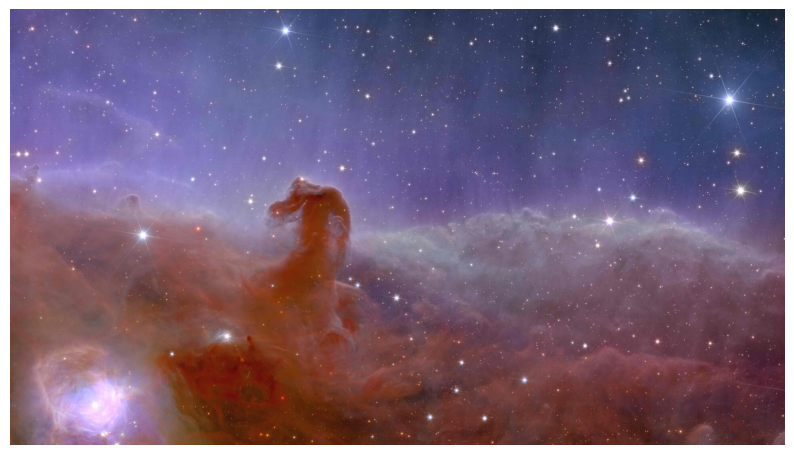

In [4]:
%matplotlib inline
rcParams['figure.figsize'] = [10.,8.]
img = mpimg.imread('/data/euc_ero_data_01/Example_Notebooks/images/press_release_horsehead.jpg')
imgplot = plt.imshow(img)
plt.axis('off');

### 1.2 Telescope comparison

View of the horsehead nebula from different telescopes

**What is the difference between JWST and Euclid?**

Where Webb can observe extremely far back in time and zoom into the details, Euclid can go fast and wide. In a single observation Euclid can record the data from an area of the sky more than one hundred times bigger than that imaged by Webb’s camera, NIRCam. This means that Euclid can map a third of the sky to the required sensitivity in six years in space – a feat that would be impossible with Webb. 

[ESA - Frequently asked questions about Euclid!](https://www.esa.int/Science_Exploration/Space_Science/Euclid/Frequently_asked_questions_about_Euclid)

https://esawebb.org/images/weic2411c/

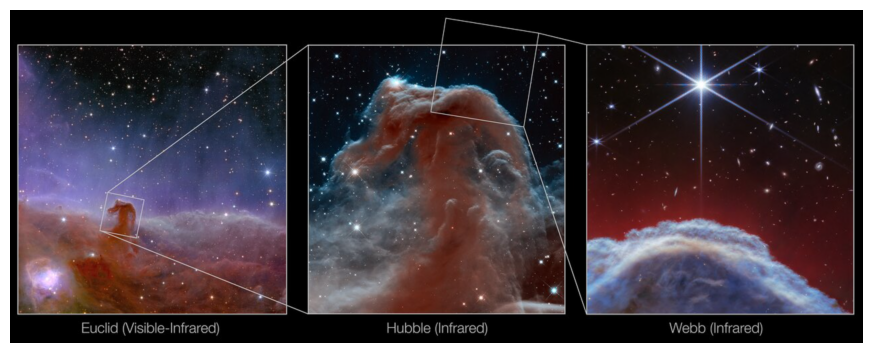

In [5]:
rcParams['figure.figsize'] = [11,9]
img_comp = mpimg.imread('/data/euc_ero_data_01/Example_Notebooks/images/comparison.PNG')
imgplot = plt.imshow(img_comp)
plt.axis('off');

### 1.3 Astronomical image colourisation

In the image below the horizontal x-axis is wavelength. The colour spectrum in the bottom left corner corresponds to eveything humans can see (400-700 nm) and the rest of the image is everything Euclid can see. VIS and NISP are the 2 instruments on board the telescope: the VISible instrument (VIS) and the Near-Infrared Spectrometer and Photometer (NISP). NISP is further divided into 3 different wavelength bands: Y, J, H. What we are attempting to do when colouring images is cramming eveything that Euclid can see into the small range of wavelengths humans are capable of comprehending. So we assign the 3 Euclid bands colours in the visible spectrum R, G and B and then layer those 3 images on top of eachother.

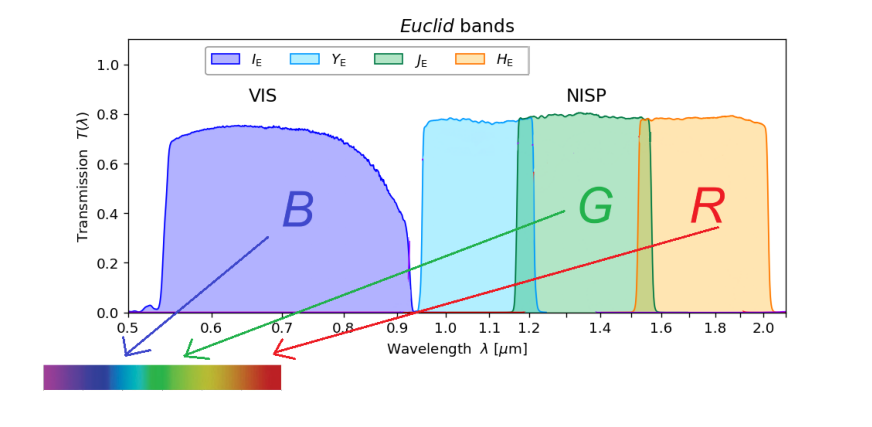

In [6]:
img_comp = mpimg.imread('/data/euc_ero_data_01/Example_Notebooks/images/euclid_transmission_mod.png')
imgplot = plt.imshow(img_comp)
plt.axis('off');

## 2. Getting actual full VIS image

In [7]:
# reading in full image
ero_volume_path = '/data/euc_ero_data_01/'
fits_file_path = ero_volume_path + 'ERO/Stack/ERO-Horsehead/Euclid-VIS-ERO-Horsehead-LSB.DR3.fits.gz'
image_data, header = fits.getdata(fits_file_path, header=True)
print("The size of original image: ", image_data.shape)
print("That is", image_data.shape[0] * image_data.shape[1], "pixels!")

The size of original image:  (36000, 36000)
That is 1296000000 pixels!


## 3. Making a cutout of the VIS image (by centre coordinates)

Image size: (18000, 18000)


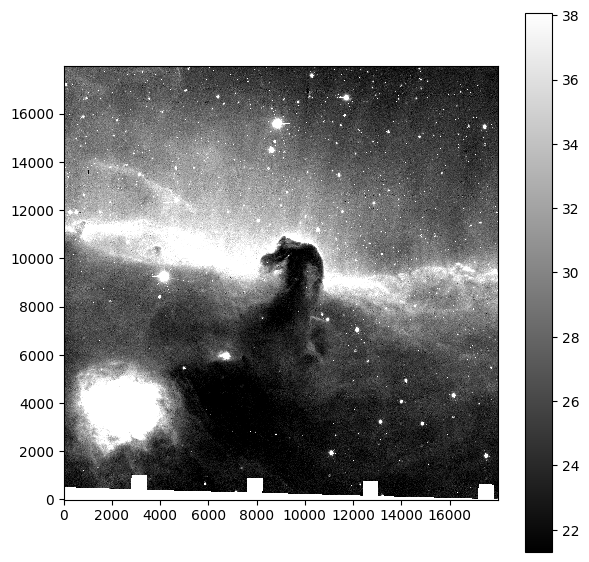

In [8]:
c = SkyCoord('05h41m04.3911s', '-2d26m24.493s', frame='icrs') #the coordinates are chosen to match the press photo
cut_vis = Cutout2D(data=image_data, position = c, size=30 * u.arcmin, wcs = wcs.WCS(header))
print("Image size:", cut_vis.shape)

# showing the cutout
rcParams['figure.figsize'] = [7.,7.]
cut_vis_rot = np.rot90(cut_vis.data, k=-1)
plt.imshow(cut_vis_rot, interpolation='nearest', cmap='gray', origin='lower', norm=ImageNormalize(cut_vis_rot, interval=PercentileInterval(90)))
plt.colorbar();

## 4. Getting and cutting the NISP images

### 4.1 NISP-H

In [9]:
fits_file_path_nisp_h = ero_volume_path + 'ERO/Stack/ERO-Horsehead/Euclid-NISP-H-ERO-Horsehead-LSB.DR3.fits.gz'
image_data_nisp_h, header_nisp_h = fits.getdata(fits_file_path_nisp_h, header=True)

Cut size (6000, 6000)


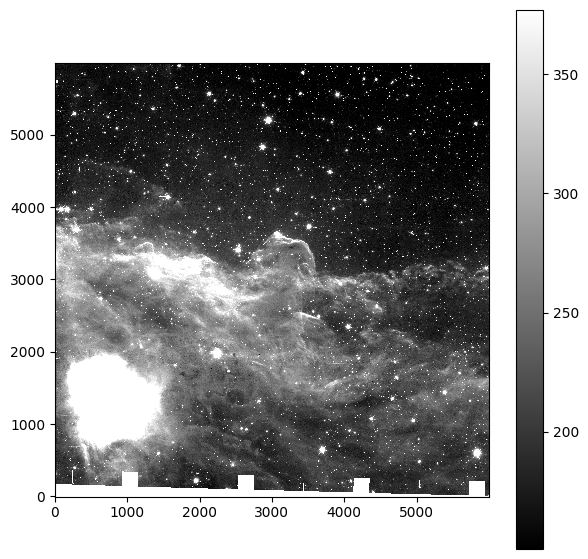

In [10]:
c = SkyCoord('05h41m04.3911s', '-2d26m24.493s', frame='icrs')
cut_nisp_h = Cutout2D(data=image_data_nisp_h, position = c, size=30 * u.arcmin, wcs = wcs.WCS(header_nisp_h))
print("Cut size", cut_nisp_h.shape)

cut_nisph_rot = np.rot90(cut_nisp_h.data, k=-1)
plt.imshow(cut_nisph_rot, interpolation='nearest', cmap='gray', origin='lower', norm=ImageNormalize(cut_nisph_rot, interval=PercentileInterval(90)))
plt.colorbar();

### 4.2 NISP-J

In [11]:
fits_file_path_nisp_j = ero_volume_path + 'ERO/Stack/ERO-Horsehead/Euclid-NISP-J-ERO-Horsehead-LSB.DR3.fits.gz'

# MODIFY HERE - uncomment the line below (and comment the one above) to use Y NISP band instead
# fits_file_path_nisp_j = '/media/team_workspaces/YPE-2024/Euclid/data/Euclid-NISP-Y-ERO-Horsehead-LSB.DR3.fits.gz'

image_data_nisp_j, header_nisp_j = fits.getdata(fits_file_path_nisp_j, header=True)

Cut size (6000, 6000)


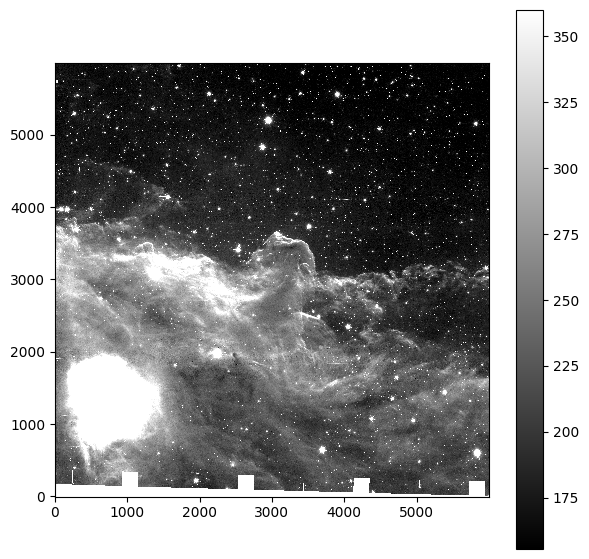

In [12]:
c = SkyCoord('05h41m04.3911s', '-2d26m24.493s', frame='icrs')
cut_nisp_j = Cutout2D(data=image_data_nisp_j, position = c, size=30 * u.arcmin, wcs = wcs.WCS(header_nisp_j))
print("Cut size", cut_nisp_j.shape)

cut_nispj_rot = np.rot90(cut_nisp_j.data, k=-1)
plt.imshow(cut_nispj_rot, interpolation='nearest', cmap='gray', origin='lower', norm=ImageNormalize(cut_nispj_rot, interval=PercentileInterval(90)))
plt.colorbar();

## 5. Downsampling VIS cutout to match in size

We want to reduce the number of pixels in the VIS image to match the size of the NISP ones. So we want to go from a 18 000 x 18 000 pixel image to 6000 x 6000 pixels. This can be done by looking at small 3 x 3 pixel blocks of the image and averaging the values of those 9 pixels. So instead of 9 pixels we have one pixel that has the mean value. Yes, we are losing some data by doing this, but we are still left with 36 million pixels, so you won’t even notice it in this notebook.

In [13]:
# image sizes before downsampling
print("VIS image size:", cut_vis.shape)
print("Nisp J image size:", cut_nisp_j.shape)
print("Nisp H image size:", cut_nisp_h.shape)

VIS image size: (18000, 18000)
Nisp J image size: (6000, 6000)
Nisp H image size: (6000, 6000)


In [14]:
# downsample VIS
downsampled_vis = block_reduce(cut_vis.data, block_size=(3, 3), func=np.mean)
print("Vis image size after downsampling:", downsampled_vis.shape)

Vis image size after downsampling: (6000, 6000)


## 6. Taking a closer look at our data

### 6.1 Getting the minimum and maximum pixel values for each image

In the grayscale images above each pixel has a value that determines how black or white it is. So the smaller the value the darker the pixel and the bigger the pixel value the whiter it is. Now we are going to check for each image what is the value of the darkest pixel and what is the value of the whitest pixel.

In [15]:
# get min and max pixel values before
print("VIS data range:", np.nanmin(downsampled_vis), "-", np.nanmax(downsampled_vis))
print("NISP J data range:", np.nanmin(cut_nisp_j.data), "-", np.nanmax(cut_nisp_j.data))
print("NISP H data range:", np.nanmin(cut_nisp_h.data), "-", np.nanmax(cut_nisp_h.data))

VIS data range: -0.13379544 - 23051.893
NISP J data range: 92.52977 - 113937.734
NISP H data range: 87.177704 - 117746.39


We can see that these ranges are quite different which shows that the white in the VIS image is not quite the same white that's in the NISP images for example (same for all the other shades too). Ideally we want these ranges to match, which is what we will be working on in the next part.

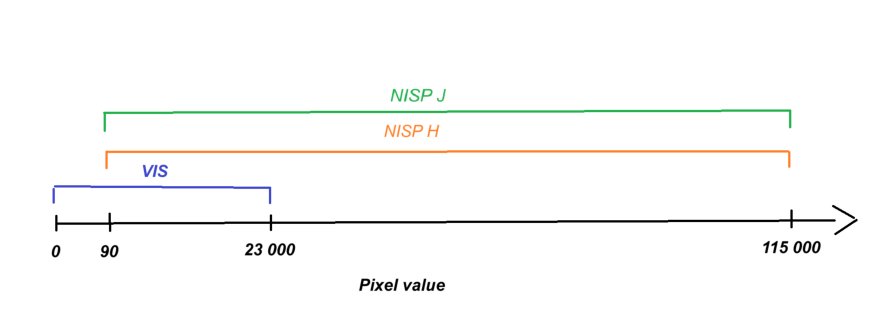

In [16]:
rcParams['figure.figsize'] = [11,9]
img_comp = mpimg.imread('/data/euc_ero_data_01/Example_Notebooks/images/pixel_ranges.png')
imgplot = plt.imshow(img_comp)
plt.axis('off');

### 6.2 Example of astronomical image histogram

An image histogram is a plot where the horisontal x-axis is the pixel value that we just talked about (how black-white a pixel is) and the vertical y-axis shows the number of pixels that have that specific value. Below you can see how an image histogram usually looks like for astronomical images. From this you can see that most of the picture is black/dark (that's the big peak) but there are also some pixels that are very bright - these are the stars. 

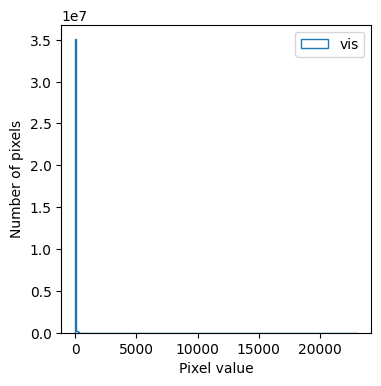

In [17]:
# plotting pixel value distributions
rcParams['figure.figsize'] = [4,4]
_ = plt.hist(downsampled_vis.ravel(), 256, histtype = 'step', label = 'vis')
_ = plt.xlabel("Pixel value")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()

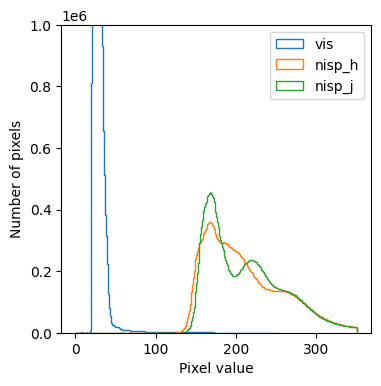

In [18]:
# plotting pixel value distributions
_ = plt.hist(downsampled_vis.ravel(), 256, range=(0, 255), histtype = 'step', label = 'vis')
_ = plt.hist(cut_nisp_h.data.ravel(), 350, range=(0, 351), histtype = 'step', label = 'nisp_h')
_ = plt.hist(cut_nisp_j.data.ravel(), 350, range=(0, 351), histtype = 'step', label = 'nisp_j')
_ = plt.xlabel("Pixel value")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
axes = plt.gca()
_ = axes.set_ylim([0,1000000])

## 7. Rescaling pixel values to match

The next code cell is where we do all the data manipulation we talked about - clipping and stretching. 

* Clipping. The PercentileInterval function takes care of the clipping. The 99 means that 99% of the data stays like it is but from either side 0.5% of the data is assigned to either the min (for lower end) or the max value.
* Stretching. Stretching is essentially remapping the data from one range to another. In case of linear stretching the former min value becomes 0 and the former max value becomes 1 and similarly for eveything in between. In our case we are using asinh stretching (inverse hyperbolic sine) which means we are not just moving the data to a new range but moving some parts of it differently than others. The idea is to leave more space in the new range for lower values and less space for brighter ones so the lower part of the histogram becomes more stretched out. This is because most of the data we are interested in is in the dark areas and this way we can see them in more detail while the bright stars will still be seen anyway.

In [19]:
# MODIFY HERE - Try different values for clipping or different stretches like SqrtStretch(), LogStretch()
transform_vis = AsinhStretch() + PercentileInterval(99.)
transform_nisp = AsinhStretch() + PercentileInterval(99.)

vis_scaled = transform_vis(downsampled_vis)
nisp_j_scaled = transform_nisp(cut_nisp_j.data)
nisp_h_scaled = transform_nisp(cut_nisp_h.data)

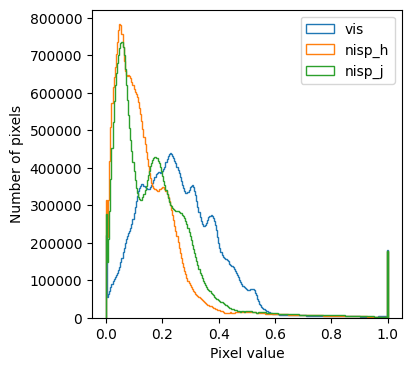

In [20]:
# new distributions
_ = plt.hist(vis_scaled.ravel(), 256, range=(0, 1), histtype = 'step', label = 'vis')
_ = plt.hist(nisp_h_scaled.ravel(), 256, range=(0, 1), histtype = 'step', label = 'nisp_h')
_ = plt.hist(nisp_j_scaled.ravel(), 256, range=(0, 1), histtype = 'step', label = 'nisp_j')
_ = plt.legend()
_ = plt.xlabel("Pixel value")
_ = plt.ylabel("Number of pixels")

## 8. Combining the three image cutouts to form one coloured image

**Order for combining the images** 

* Euclid VIS (Visual instrument) measures light in the visible spectrum so from 550 nanometres up to near-infrared at 900 nm.
* Euclid NISP (The Near Infrared Spectrometer and Photometer) measures light in 3 bands: Y, J, H. Each letter designates a section of light of the electromagnetic spectrum (the number corresponds to the effective wavelength midpoint for standard filter)
    * Y – 1020 nm
    * J – 1220 nm
    * H – 1630 nm

The three images we used are VIS, NISP-J and NISP-H and in the code below we are assigning them to RGB bands in the logical order from highest to lowest wavelength:  NISP-H, NISP-J, VIS. Also see image at the beginning of the notebook about Euclid bands.

**Algorithm for combining the images**

We are creating the RGB image using the [Lupton et al (2004)](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract) scheme where

$ f(x) = \frac{asinh ( \alpha Q (x-m))}{Q} $

* stretch - the linear stretch of the image ($\alpha$ in equation)
* Q - the asinh softening parameter

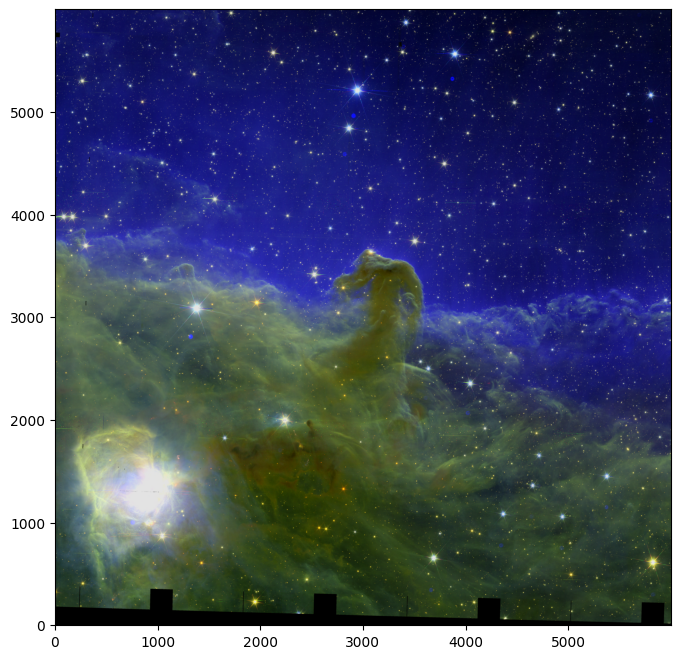

In [21]:
rcParams['figure.figsize'] = [8,8]

# creating the colour image
# MODIFY HERE - try testing differrent image orders and Q and stretch values to see what happens
rgb_default = make_lupton_rgb(nisp_h_scaled, nisp_j_scaled, vis_scaled, Q=2, stretch=0.7)

# rotate and save colour image
rgb_default_rot = np.rot90(rgb_default, k=-1)
rgb_downsample = block_reduce(rgb_default_rot, block_size=(10, 10, 1), func=np.mean)

# show the colour image
plt.imsave(output_folder + 'RGB.png', np.asarray(rgb_downsample, dtype="uint8"), origin='lower')
_ = plt.imshow(rgb_default_rot, origin='lower')

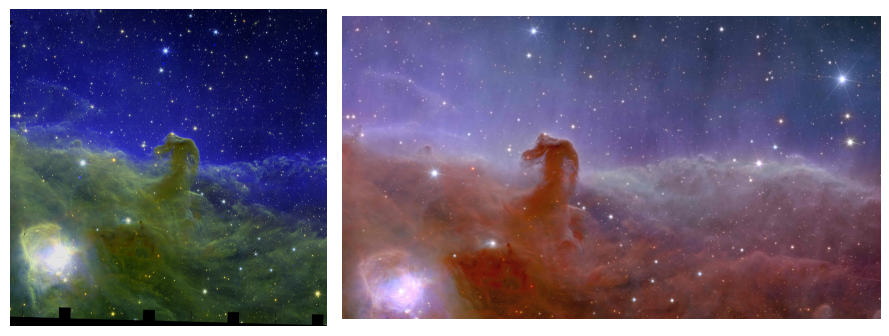

In [22]:
# comparison with the press foto
rcParams['figure.figsize'] = [9,9]
f, axarr = plt.subplots(1,2, width_ratios=[1, 1.7])
axarr[0].imshow(rgb_default_rot, origin='lower')
axarr[0].set_axis_off()
axarr[1].imshow(img)
axarr[1].set_axis_off()
_ = plt.tight_layout()

## Extra: Automatic source extraction

In [23]:
small_data = cut_nisp_h.data.byteswap().newbyteorder()

# background subtraction
c_contiguous_data = np.ascontiguousarray(small_data)
bkg = sep.Background(c_contiguous_data)
data_sub = c_contiguous_data - bkg

# source extraction
sources = sep.extract(data_sub, 8.0, err=bkg.globalrms, minarea=5000, deblend_cont=1.0)

# filtering out sources by flux
sources_thr = sources[(sources['flux'] > 20000000) & (sources['flux'] < 50000000)]

print("Found", len(sources_thr), "objects above flux threshold")

Found 6 objects above flux threshold


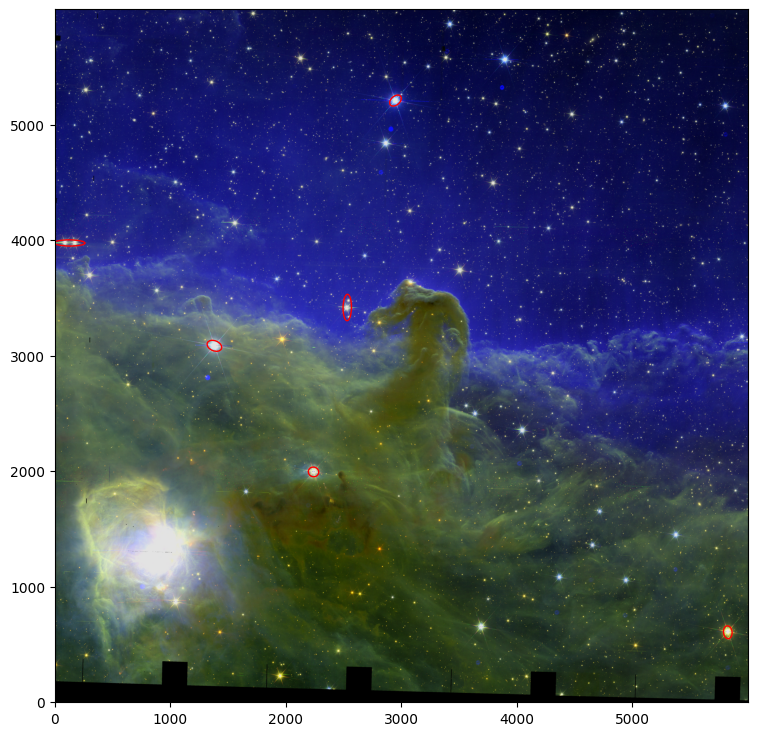

In [24]:
# plotting found sources
x_rot = 6000 - sources_thr['y']
y_rot = sources_thr['x']

# plot background-subtracted image
fig, ax = plt.subplots()
im = ax.imshow(rgb_default_rot, origin='lower')

# plot an ellipse for each object
for i in range(len(sources_thr)):
    e = Ellipse(xy=(x_rot[i], y_rot[i]),
                width=6*sources_thr['a'][i],
                height=6*sources_thr['b'][i],
                angle=(sources_thr['theta'][i] * 180. / np.pi) - 90)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

***